In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm

img_dir = './img/'
if not exists(img_dir):
    makedirs(img_dir)


# 1. Functions

In [85]:
def prepare_gdf(year, level):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlace_spain_v_outside/'
    file_extension = '_birthPlace_spain_v_outside.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)

    # avoid data type issues
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

    # --- INITIAL DATA PROCESSING ---
    # separate spain vs outside spain
    spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

    outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

    # merge into single dataframe
    spain_vs_outside = pd.merge(spain, outside_spain, on=level, how='outer').fillna(0)

    # compute relevant metrics
    spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']
    spain_vs_outside['Immigrant_percentage'] = spain_vs_outside['Population_outside_Spain'] / spain_vs_outside['Total_population'] * 100

    # --- MERGE WITH GEOMETRY AND MORE PROCESSING ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, spain_vs_outside, left_on=level, right_on=level, how='left')

    # compute additional metrics
    df['Area_km2'] = df['Geometry_etrs89'].area / 1e6  # area in square kilometers
    df['Population_density'] = df['Total_population'] / df['Area_km2']
    df['Immigrant_density'] = df['Population_outside_Spain'] / df['Area_km2']

    return df

def plot_density(year, level, ax):
    global vmin, vmax

    gdf = prepare_gdf(year, level)

    gdf.plot(column='Population_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def plot_immigrant_density(year, level, ax):
    global vmin, vmax
    gdf = prepare_gdf(year, level)

    gdf.plot(column='Immigrant_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def add_legend(fig, level):
    global vmin, vmax

    # --- NEW AXIS FOR THE LEGEND ---
    norm = LogNorm(vmin=vmin, vmax=vmax)
    cmap = cm.cividis
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # make space for the legend
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

    # --- COLORBAR ---
    cbar = fig.colorbar(sm, cax=cbar_ax)

    cbar.set_label('Population Density per km$^2$', 
                fontsize=30, 
                fontweight='bold', 
                rotation=270, 
                labelpad=55)  

    # --- TICK PARAMETERS ---
    cbar.ax.tick_params(
        labelsize=18,
        length=8,                    
        width=4,                     
        color='black',               
        pad=10,                      
        direction='out'              
    )
    cbar.ax.tick_params(axis='y', labelrotation=270)

    if level == 'District':
        ticks = [1000, 3000, 10000, 30000]
    elif level == 'Neighborhood':
        ticks = [300,1000, 3000, 10000, 30000]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:,}" for t in ticks])  # formatted with commas

    cbar.ax.tick_params(labelsize=23, length=8, width=4, pad=10)


# 2. Density Maps

## 2.1. Districts (ruled out)

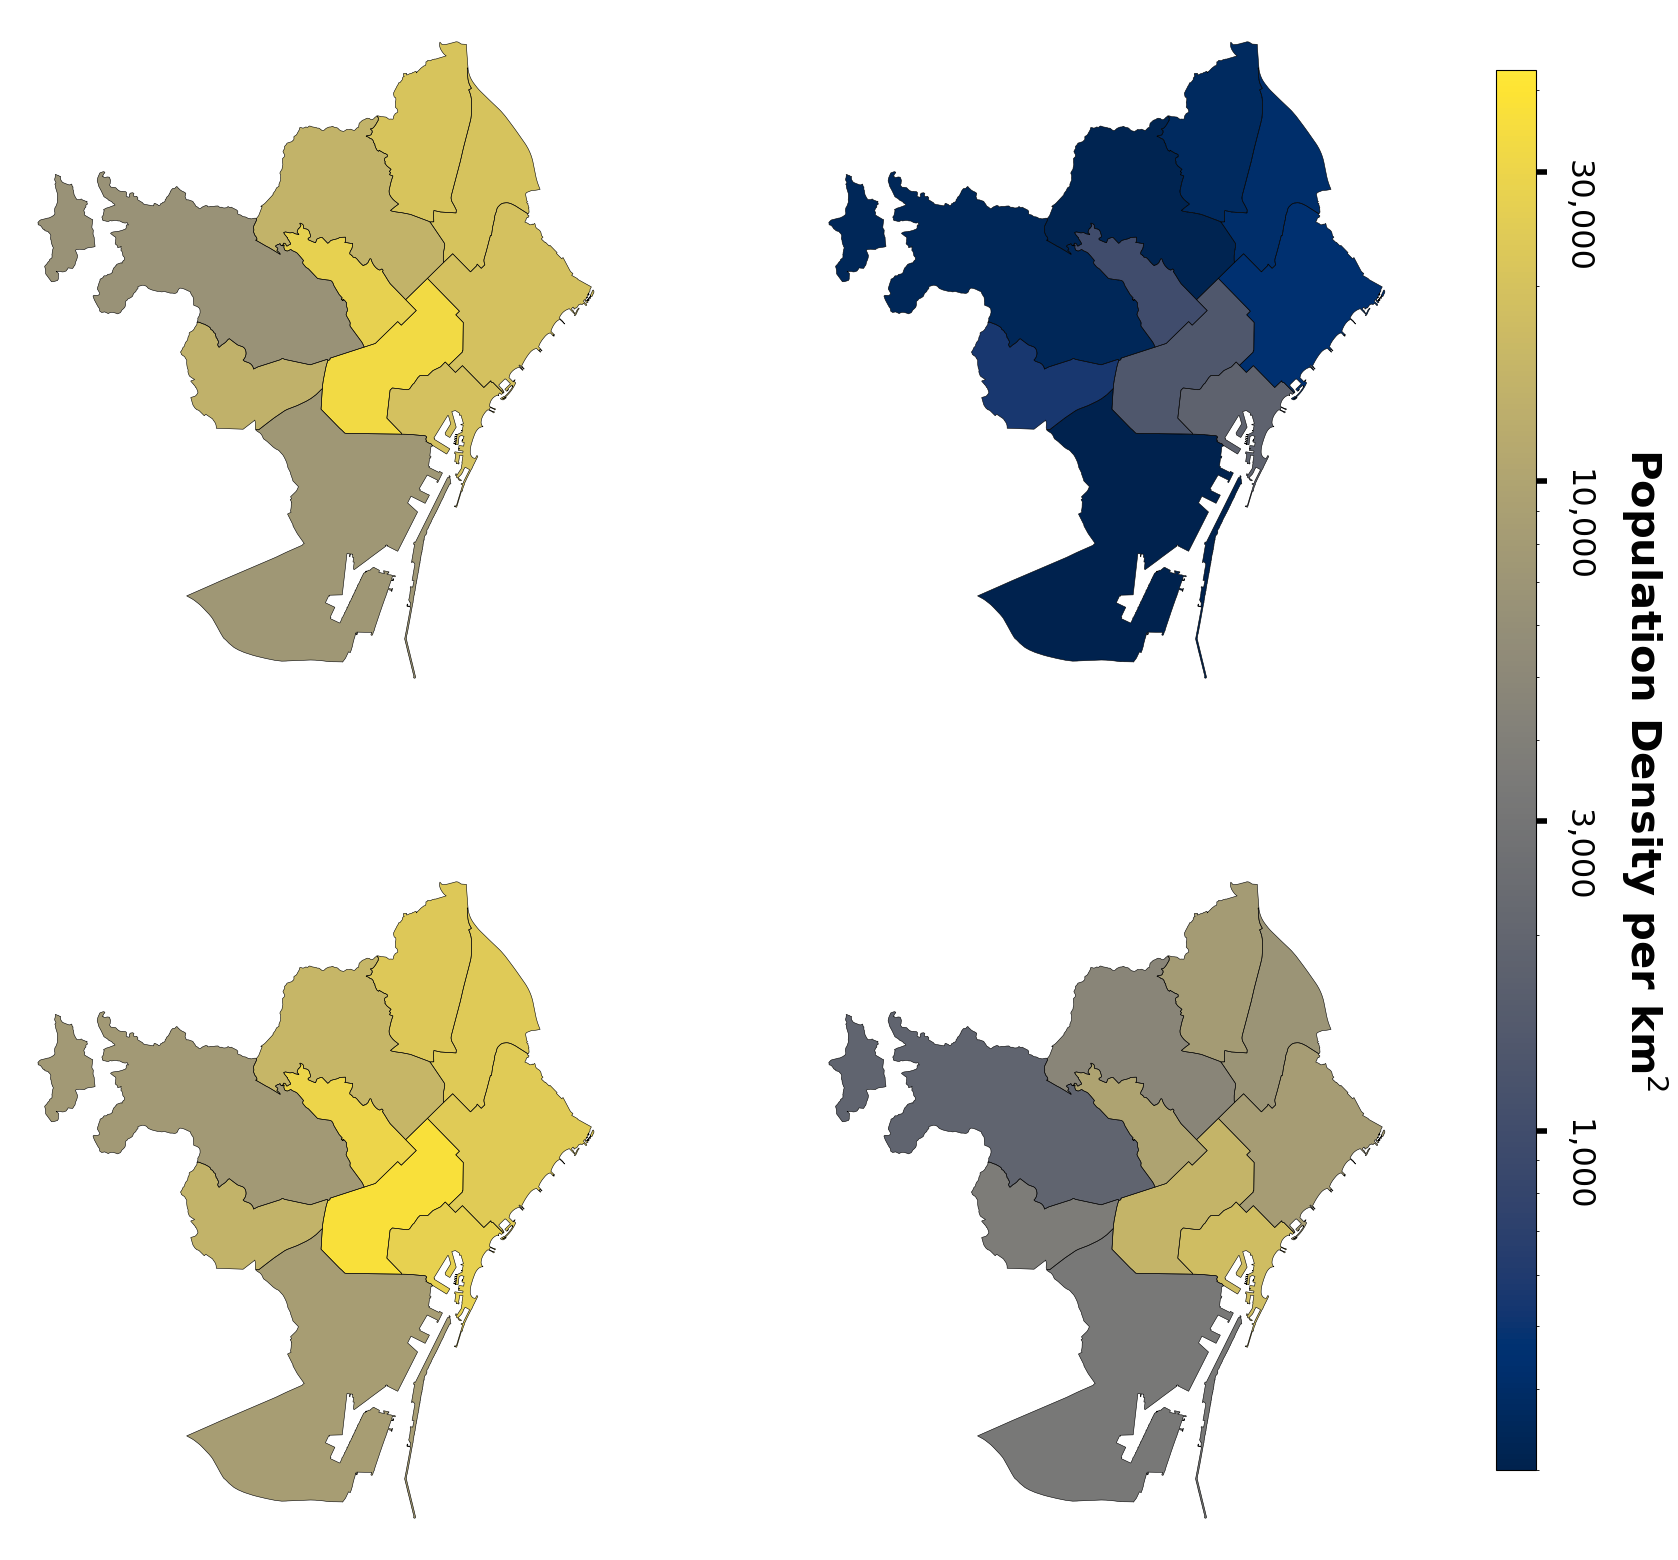

In [86]:
level = 'District'
vmin, vmax = 3000, 50000    # no se ve 1997 imm - todo azul
vmin, vmax = 600, 60000     # recupera algo de color, pero mucho azul
vmin, vmax = 300, 43000     # se ve bien, densidad total algo amarilla de más

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plot_density(1997, level, axs[0,0])
plot_density(2025, level, axs[1,0])
plot_immigrant_density(1997, level, axs[0,1])
plot_immigrant_density(2025, level, axs[1,1])

add_legend(fig, level)

plt.show()


## 2.2. Neighborhoods

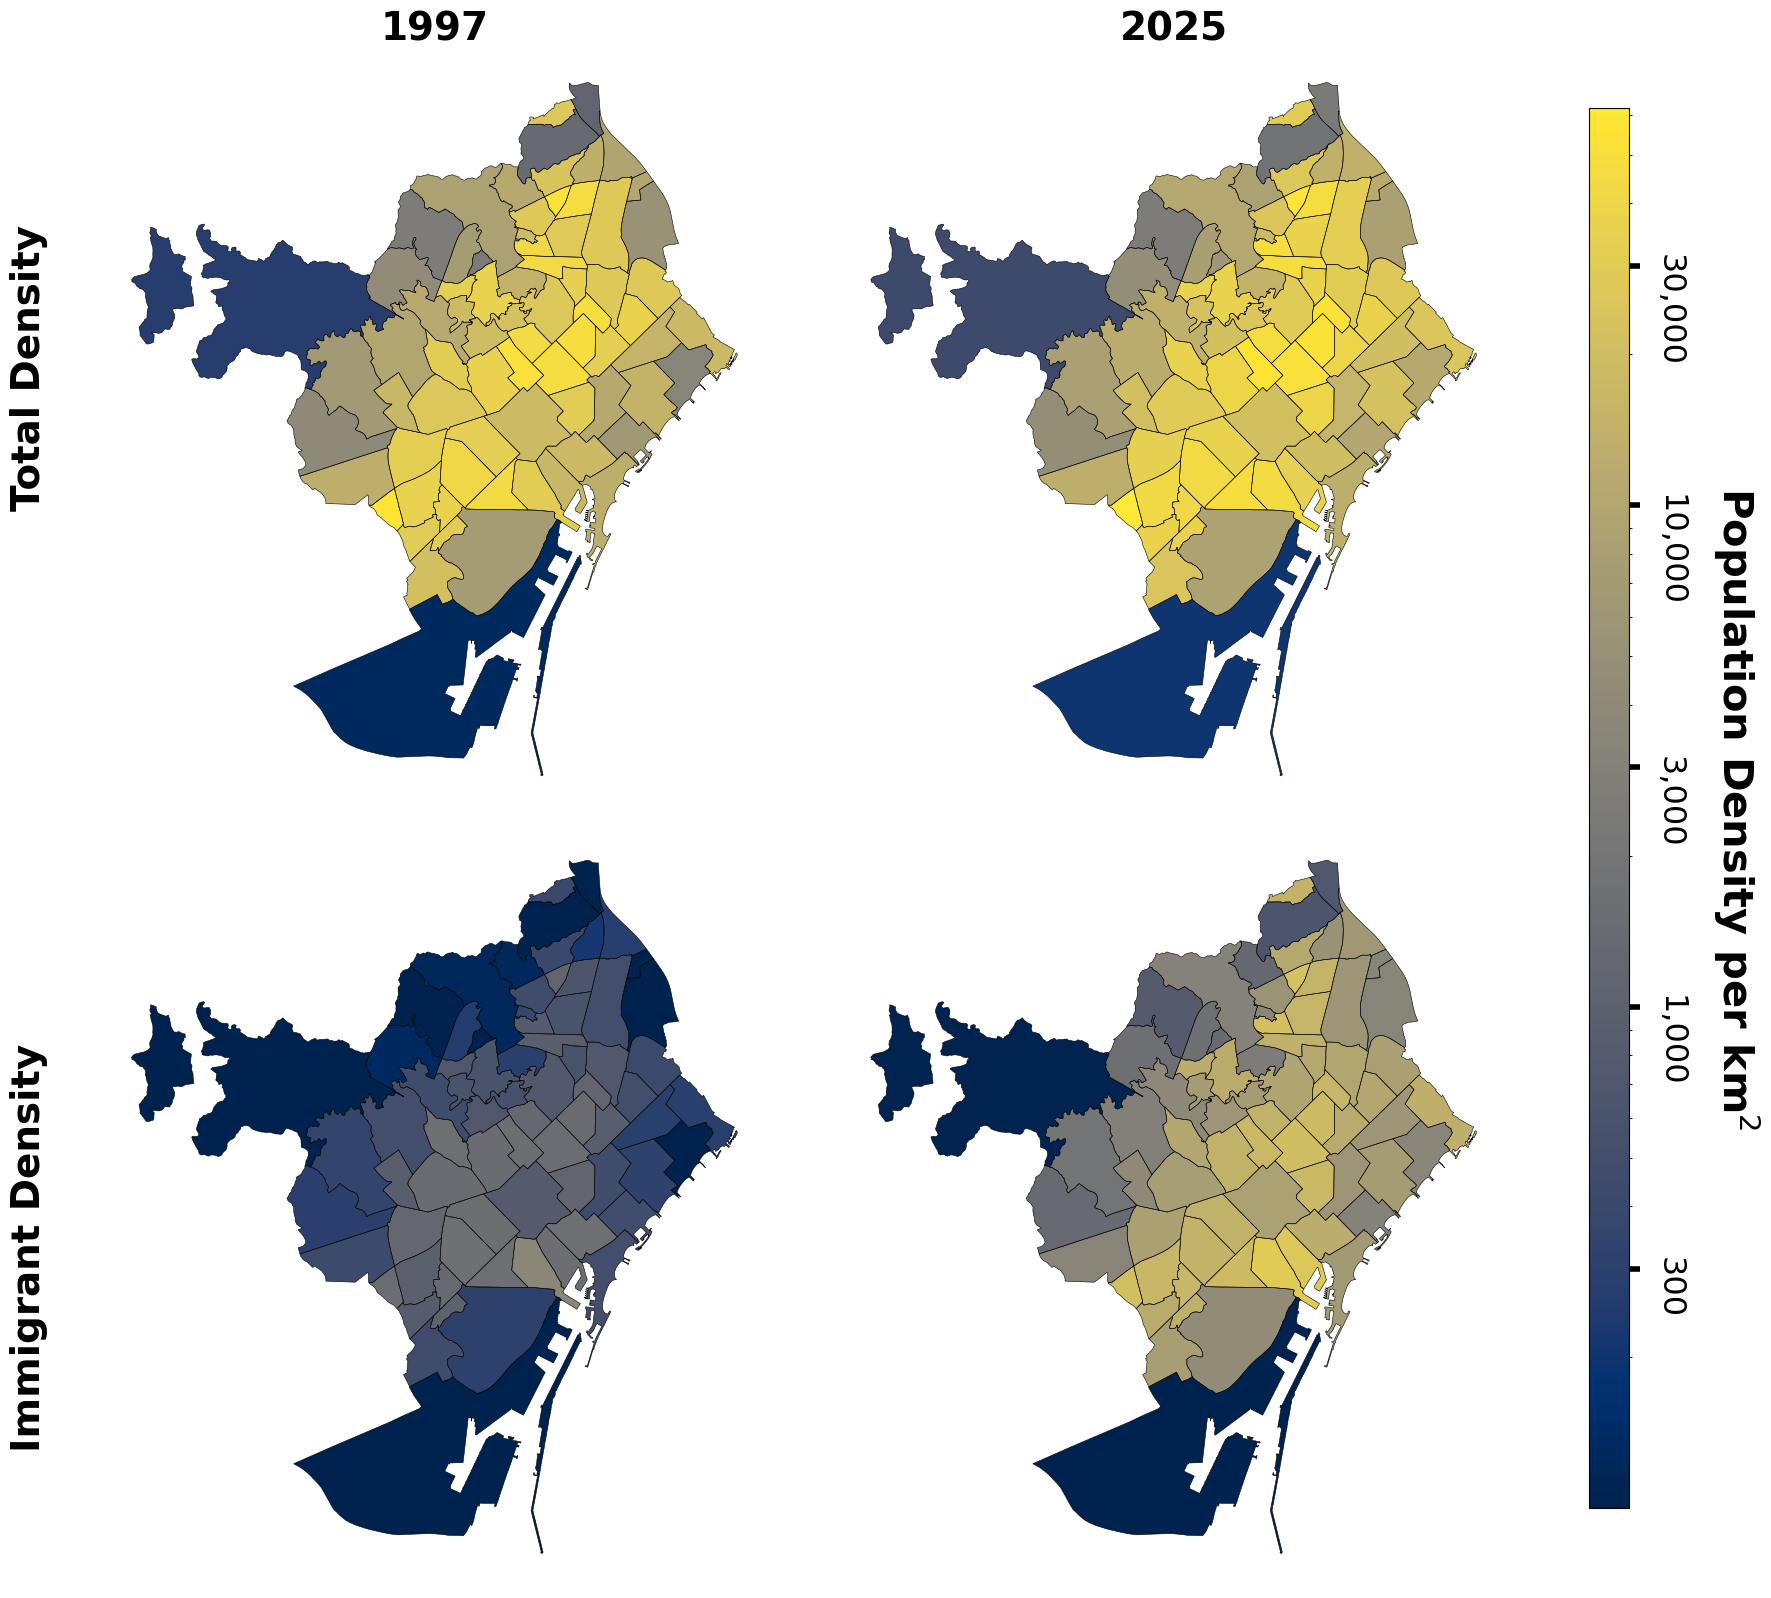

In [87]:
level = 'Neighborhood'
vmin, vmax = 100, 62000     # se ve bien, densidad total algo amarilla de más

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plt.subplots_adjust(wspace=0.04, hspace=0.02)

axs[0,0].set_title('1997', fontsize=28, fontweight='bold')
axs[0,1].set_title('2025', fontsize=28, fontweight='bold')
fig.text(0.10, 0.72, 'Total Density', fontsize=28, rotation=90, 
         ha='center', va='center', weight='bold')
fig.text(0.10, 0.28, 'Immigrant Density', fontsize=28, rotation=90, 
         ha='center', va='center', weight='bold')

plot_density(1997, level, axs[0,0])
plot_immigrant_density(1997, level, axs[1,0])

plot_density(2025, level, axs[0,1])
plot_immigrant_density(2025, level, axs[1,1])

add_legend(fig, level)

plt.savefig(img_dir + 'density_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


In [88]:
gdf = prepare_gdf(1997, 'Neighborhood')

display(gdf[['Neighborhood', 'Immigrant_percentage']].sort_values(by='Immigrant_percentage', ascending=False))
display(gdf['Immigrant_percentage'].describe())


,Neighborhood,Immigrant_percentage
0,el Raval,11.462427
3,"Sant Pere, Santa Caterina i la Ribera",9.389813
1,el Barri Gòtic,9.363710
66,la Vila Olímpica del Poblenou,7.430289
20,Pedralbes,7.144823
...,...,...
58,el Bon Pastor,1.275536
48,Canyelles,1.134931
41,la Clota,1.126126
55,Vallbona,0.706215


count    73.000000
mean      3.176345
std       2.033358
min       0.700832
25%       1.769602
50%       2.726678
75%       4.003257
max      11.462427
Name: Immigrant_percentage, dtype: float64

# 3. Density Curves for some Neighborhoods (ruled out)

In [89]:
# --- PREPARE TIME SERIES DF ---
records = []  # accumulate rows here

for year in range(1997, 2026):
    gdf = prepare_gdf(year, 'Neighborhood')

    # keep only the columns we need
    subset = gdf[[
        "District",
        "Neighborhood",
        "Population_density",
        "Immigrant_density"
    ]].copy()

    subset["Year"] = year
    records.append(subset)

# concatenate into a single long dataframe
df_ts = pd.concat(records, ignore_index=True)

# --- FIND CONVERGENCES AND DIVERGENCES ---
results = []

for nb, df_nb in df_ts.groupby("Neighborhood"):
    df_nb = df_nb.sort_values("Year")

    # compute difference each year
    diff = df_nb["Population_density"] - df_nb["Immigrant_density"]

    # compute slope of diff over time
    years = df_nb["Year"]
    slope, intercept = np.polyfit(years, diff, 1)

    results.append({
        "Neighborhood": nb,
        "MeanDifference": diff.mean(),
        "SlopeDifference": slope
    })

df_stats = pd.DataFrame(results).sort_values("SlopeDifference")

# print('Convergences (negative slope):' df_stats.head(3))
# print('Divergences (positive slope):' df_stats.tail(3))
df_stats.tail(10)





,Neighborhood,MeanDifference,SlopeDifference
56,la Marina del Prat Vermell,88.775005,-1.313920
17,Sant Gervasi - la Bonanova,9474.122726,-0.046313
22,Sarrià,6624.041912,1.589481
26,"Vallvidrera, el Tibidabo i les Planes",310.212075,3.294176
24,Vallbona,1650.650751,19.574498
68,la Vila Olímpica del Poblenou,7465.143535,30.417012
43,el Poblenou,15948.949985,38.336667
72,les Tres Torres,17276.457261,44.690851
50,la Clota,2605.647857,45.707020
5,Diagonal Mar i el Front Marítim del Poblenou,6822.679207,189.328826


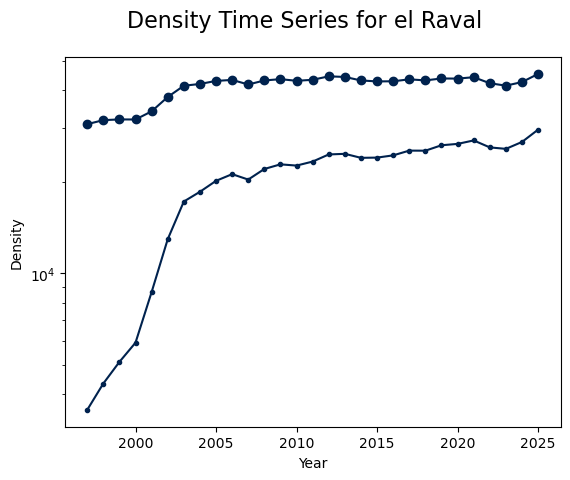

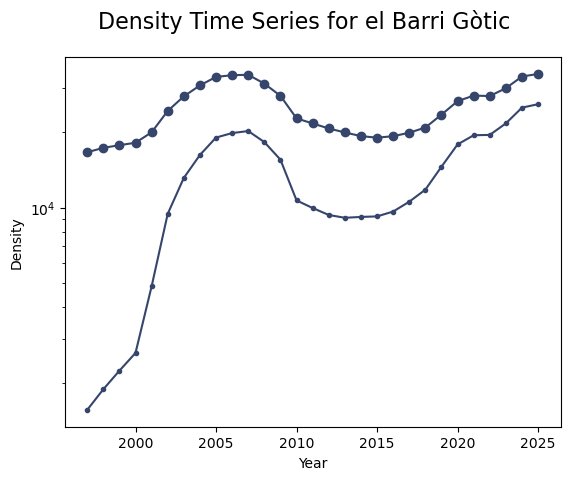

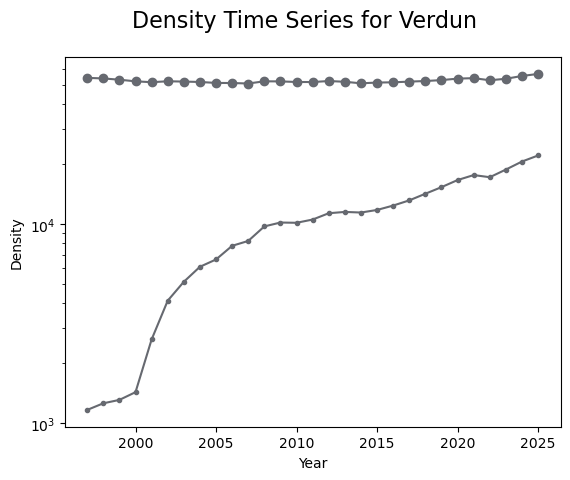

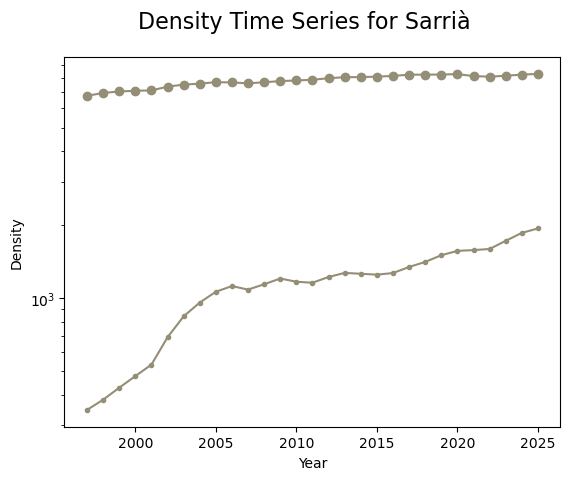

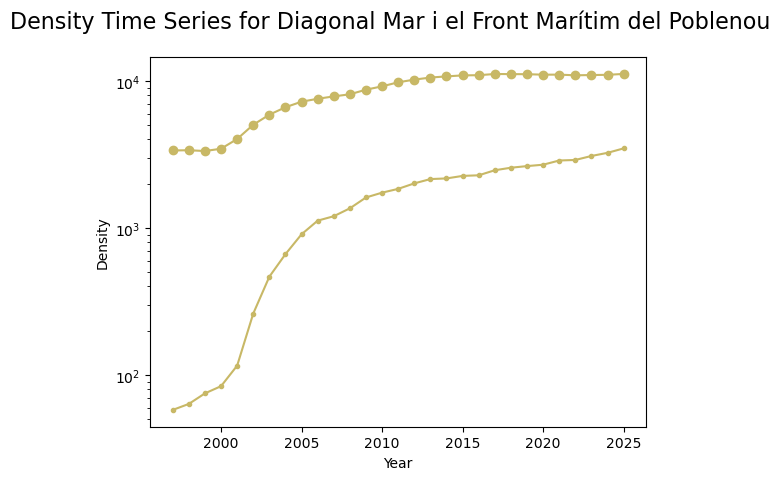

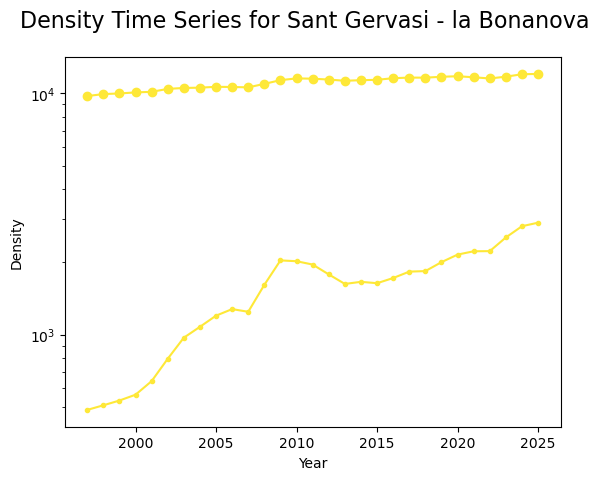

In [90]:
# --- PREPARE TIME SERIES DF ---
years = range(1997, 2026)
neighborhoods_of_interest = [
    "el Raval",
    "el Barri Gòtic",
    'Verdun',
    'Sarrià',
    'Diagonal Mar i el Front Marítim del Poblenou',
    'Sant Gervasi - la Bonanova',
]

records = []  # accumulate rows here

for year in years:
    gdf = prepare_gdf(year, 'Neighborhood')

    # keep only the columns we need
    subset = gdf[[
        "District",
        "Neighborhood",
        "Population_density",
        "Immigrant_density"
    ]].copy()

    subset["Year"] = year
    records.append(subset)

# concatenate into a single long dataframe
df_ts = pd.concat(records, ignore_index=True)

# --- PLOT TIME SERIES ---
colors = cm.cividis(np.linspace(0, 1, len(neighborhoods_of_interest)))

for neighborhood in neighborhoods_of_interest:
    fig, ax = plt.subplots()
    df_neigh = df_ts[df_ts['Neighborhood'] == neighborhood]

    ax.plot(df_neigh['Year'], df_neigh['Population_density'], label='Population Density', marker='o', color=colors[neighborhoods_of_interest.index(neighborhood)])
    ax.plot(df_neigh['Year'], df_neigh['Immigrant_density'], label='Immigrant Density', marker='.', color=colors[neighborhoods_of_interest.index(neighborhood)])

    ax.set_xlabel("Year")
    ax.set_ylabel("Density")

    ax.set_yscale('log')
    
    # ax.legend()

    fig.suptitle(f"Density Time Series for {neighborhood}", fontsize=16)
    plt.show()

